<a href="https://colab.research.google.com/github/Echo9k/OSIC_Pulmonary_Fibrosis_Progression/blob/master/OSIC_Pulmonary_Fibrosis_Progression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>OSIC Pulmonary Fibrosis Progression</h1>
<h2>Predict lung function decline</h2>

This is split roughly 15-85 between public-private.<br>
The relative timing of FVC measurements varies widely

---
Column's meaning:
* **Patient**- a unique Id for each patient (also the name of the patient's DICOM folder)
* **Weeks**- the relative number of weeks pre/post the baseline CT (may be negative)
* **FVC** - the recorded lung capacity in ml
* **Percent**- a computed field which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics
* **Age**: Patient's age
* **Sex**: Categorical [Male/Female]
* **SmokingStatus**: Smoker, or Ex-smoker, or Never smoked




# Taking a look on the relational data

In [1]:
#@title Set up
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import numpy as np
import pandas as pd
from scipy import stats
from IPython.display import display

!pip3 install -q -U seaborn
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set_palette('deep')
mpl.rcParams['figure.figsize'] = (9,12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

!pip3 install -q -U sklearn
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#@markdown Original training data stored as pandas.DataFrame: train_table_df
train_url = "https://storage.googleapis.com/kagglesdsdata/competitions/20604/1357052/train.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1600529790&Signature=WURIvwUnjW0inI%2BprMsvas0BjJ4rn2sIDrFzNQdThWxhIPt6yef471fCCGljCu3AXiYt1mtJhwYT%2FZlQ0QRJD2D7XzScWzpt6LMOzbGR9BmkUHoUvFHrzshnx1ekZNGdzdHZSwYpTjN93tfPv6GUDDpn2Kb85v792n2lEUszmrmPI04vpyXS5fqmm0Gv9Xex8ynwsaqWuMDJPulOrJ06pdbhkrfyq9g8fWaFl79AkpV2AfBpGpzzBvFXrJWCGnSibdj8d%2FIRJqFYfeJpFsPmeYMdQf3U7M0wbwjVNgr3UmoGCMkY8PPTL3OMSYoGoiewJKrgkc%2FlNor8CN8fPR7uFQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.csv"
data = {'train_data' : pd.read_csv(train_url, index_col='Patient',
                                    dtype={'Patient':'object',
                                            'Weeks':np.int16,
                                            'FVC':np.int32,
                                            'Percent':np.float64,
                                            'Age':np.int8,
                                            'Sex':'category',
                                            'SmokingStatus':'category'})}
"data ready: data['train_data']"

"data ready: data['train_data']"

In [2]:
#@title Preprocessing
#@markdown ### Data by type
#@markdown * data_boolean: One hot encoded columns
#@markdown * data_numeric: Numerical data values
data['numeric'] = data['train_data'].drop(columns=['Sex', 'SmokingStatus'])

#@markdown * **OneHotEncoding** applayed to column SmokingStatus
#@markdown * **Binarizing** column sex to. True if is male, False otherwise
ohe = sklearn.preprocessing.OneHotEncoder(sparse=False, dtype=np.bool)
smoker_array = ohe.fit_transform(data['train_data'][['SmokingStatus']])
smoker_stack = np.stack(smoker_array, 1)
data['boolean'] = pd.DataFrame().assign(isMale = data['train_data'].Sex=='Male',
                                    currently_smokes = smoker_stack[0],
                                    ex_smoker = smoker_stack[1],
                                    never_smoked = smoker_stack[2])

#@markdown ### Normalization
#@markdown data_normalized: Normalized and encoded data
scaler = sklearn.preprocessing.RobustScaler()  # To normalize data
data['normalized'] = scaler.fit_transform(data['numeric']) # Normalize
data['normalized'] = pd.DataFrame(data['normalized'],
                            data['numeric'].index,
                            data['numeric'].columns)
# dataframe summaries
display(ohe.categories_)  # smoker categories
display(data['normalized'].describe())  # numeric variables
display(data['boolean'].describe())  # As bool 
display(data['boolean'].astype(np.int8).describe())  # booleans as numeric

[array(['Currently smokes', 'Ex-smoker', 'Never smoked'], dtype=object)]

,Weeks,FVC,Percent,Age
count,1549.000000,1549.000000,1549.000000,1549.000000
mean,0.110338,0.046590,0.077388,-0.090166
std,0.664216,0.784153,0.768690,0.784155
min,-0.942857,-1.708098,-1.814747,-2.111111
25%,-0.457143,-0.500942,-0.498063,-0.555556
50%,0.000000,0.000000,0.000000,0.000000
75%,0.542857,0.499058,0.501937,0.444444
max,3.000000,3.538606,3.004007,2.222222


,isMale,currently_smokes,ex_smoker,never_smoked
count,1549,1549,1549,1549
unique,2,2,2,2
top,True,False,True,False
freq,1224,1467,1038,1120


,isMale,currently_smokes,ex_smoker,never_smoked
count,1549.000000,1549.000000,1549.000000,1549.000000
mean,0.790187,0.052937,0.670110,0.276953
std,0.407306,0.223981,0.470325,0.447638
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


Questions to answer:
* Shape of data
    * is it balanced?
* Correlation: Weeks-FVC
* Prevalecence: Age - Weeks
* Prevalecence: Age - FVC
* Prevalecence: SmokingStatus - Percent

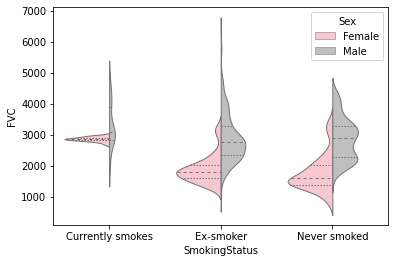

In [3]:
sns.violinplot(x='SmokingStatus', y='FVC',
                hue='Sex', split=True,
                data=data['train_data'],
                inner="quart", linewidth=1,
                palette={'Male': ".75", 'Female': "pink"},
                ci="sd", alpha=.6, height=12)

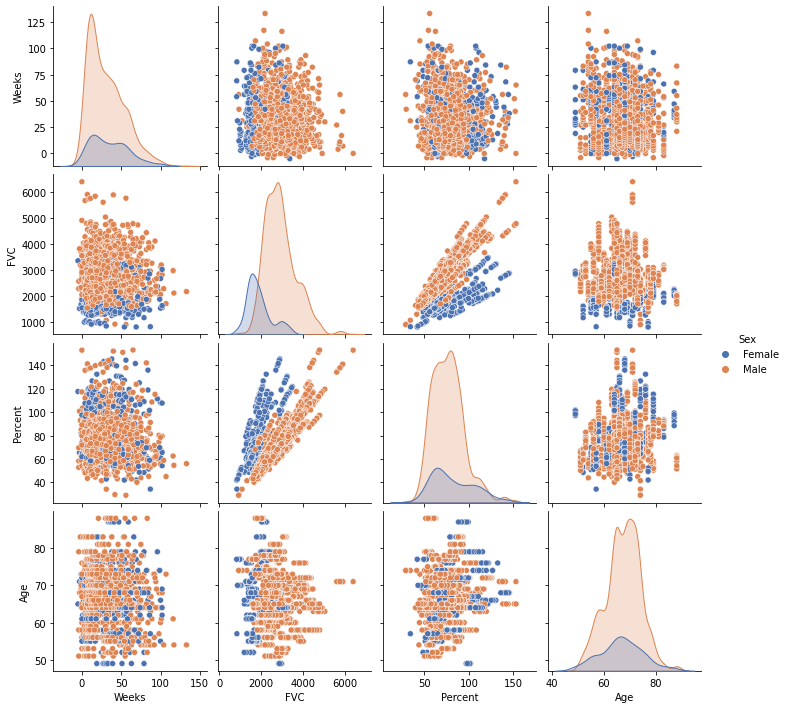

In [4]:
sns.pairplot(data['train_data'], hue='Sex')

In [5]:
#@title Statistics
#@markdown Bootstrap sampling function: multiple_balanced_sampling
def multiple_balanced_sampling(data, group_by, epochs=100, samples=1_000):
    def item_to_front(ls, value):
        list_ = list(ls)
        try:
            val_index = list_.index(value)
            list_.insert(0, list_.pop(val_index))
        except ValueError:
            list_.insert(0, group_by)
        return list_
    
    col_names = item_to_front(data.columns, group_by)
    def sample_balanced(data, categories = set(data[group_by])):
        def sampler(data, category, col_names=col_names):
            sub_df = data[data[group_by]==category]
            sample = sub_df.sample(samples, replace=True)
            return sample.groupby([group_by]).mean().reset_index()
        return np.vstack([sampler(data, cat) for cat in categories])
    samples_list = np.vstack([sample_balanced(data) for i in range(epochs)])
    return pd.DataFrame(samples_list, columns=col_names).dropna()

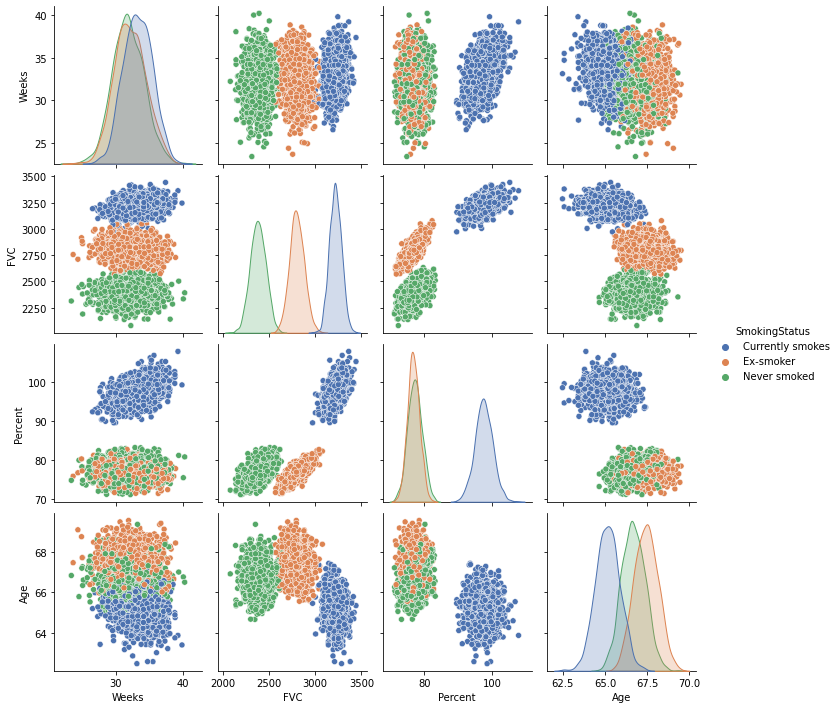

In [6]:
# markdown
samples = 1500 #@param {type:"slider", min:100, max:10000, step:100}
epochs = 100 #@param {type:"slider", min:10, max:1000, step:10}
category = "SmokingStatus" #@param ["Sex", "SmokingStatus"] {allow-input: true}
#
key_ = "bs_" + category
data[key_] = data['numeric'].copy()
data[key_] = data['numeric'].join(data['train_data'][category])
data[key_] = multiple_balanced_sampling(data[key_], category, samples, epochs)
# # correcting dtypes
data[key_] = data[key_].infer_objects()
data[key_][category] = data[key_][category].astype('category')
# viz
sns.pairplot(data[key_], hue=category)

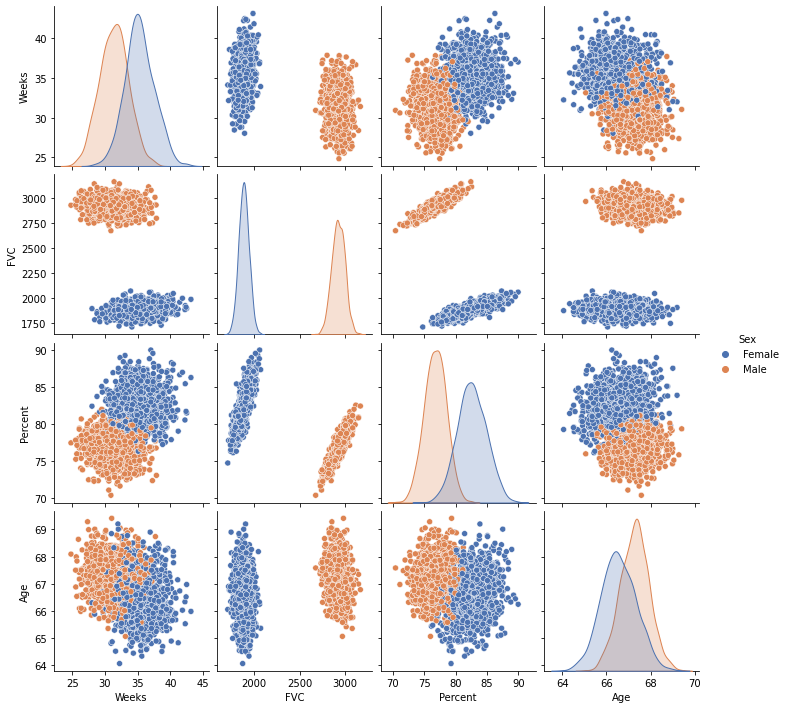

In [7]:
# markdown
samples = 1300 #@param {type:"slider", min:100, max:10000, step:100}
epochs = 110 #@param {type:"slider", min:10, max:1000, step:10}
category = "Sex" #@param ["Sex", "SmokingStatus"] {allow-input: true}
#
key_ = "bs_" + category
data[key_] = data['numeric'].copy()
data[key_] = data['numeric'].join(data['train_data'][category])
data[key_] = multiple_balanced_sampling(data[key_], category, samples, epochs)
# # correcting dtypes
data[key_] = data[key_].infer_objects()
data[key_][category] = data[key_][category].astype('category')
# viz
sns.pairplot(data[key_], hue=category)

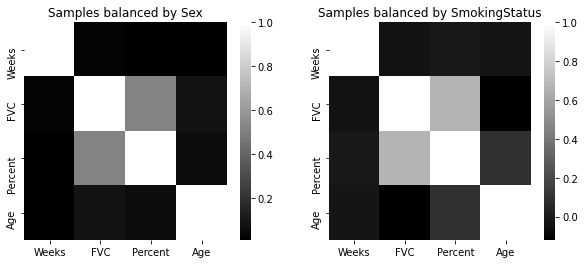

In [9]:
#@title Correlations
#@markdown Remember that Pearson assumes the data is gaussian distributed.
normalized_data = True #@param {type:"boolean"}
if normalized_data:
    data_source = "normalized"
else:
    data_source = "train_data"
method_1 = "kendall" #@param ["spearman", "kendall", "pearson"]
corr_bs_1 = data[data_source].corr(method_1)
corr_bs_1 = corr_bs_1.abs()

method_2 = "spearman" #@param ["spearman", "kendall", "pearson"]
corr_bs_2 = data[data_source].corr(method_2)
corr_bs_1 = corr_bs_1.abs()

f, axis = plt.subplots(1, 2, figsize=(10, 4))
axis[0].set_title("Samples balanced by Sex")
sns.heatmap(corr_bs_1, cmap='gray', ax = axis[0])
axis[1].set_title("Samples balanced by SmokingStatus")
sns.heatmap(corr_bs_2, cmap='gray', ax = axis[1])